In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

In [ ]:
! rm -f /root/.kaggle
! mkdir /root/.kaggle
! ls -al /root/.kaggle
! mv kaggle.json /root/.kaggle

total 12
drwxr-xr-x 2 root root 4096 Mar  4 12:21 .
drwx------ 1 root root 4096 Mar  4 12:21 ..


In [ ]:
import kaggle

In [ ]:
!kaggle competitions download -c plant-pathology-2020-fgvc7

 98% 763M/779M [00:05<00:00, 198MB/s]
100% 779M/779M [00:05<00:00, 139MB/s]


In [ ]:
! unzip -q /content/plant-pathology-2020-fgvc7.zip

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
df_train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
#unique_labels
unique_class=['healthy','multiple_diseases','rust','scab']

In [ ]:
#converting labels into an array
y=np.array([df_train['healthy'],df_train['multiple_diseases'],df_train['rust'],df_train['scab']],order='A')
y=np.transpose(y)

In [ ]:
df_train['classes']=list(y)

In [ ]:
df_train.head()

,image_id,healthy,multiple_diseases,rust,scab,classes
0,Train_0,0,0,0,1,"[0, 0, 0, 1]"
1,Train_1,0,1,0,0,"[0, 1, 0, 0]"
2,Train_2,1,0,0,0,"[1, 0, 0, 0]"
3,Train_3,0,0,1,0,"[0, 0, 1, 0]"
4,Train_4,1,0,0,0,"[1, 0, 0, 0]"


In [ ]:
#creating a label column which will have value of each label
labels=[]
label_index=[]
for i in df_train['classes']:
    label_index.append(np.argmax(i))
    labels.append(unique_class[np.argmax(i)])

In [ ]:
df_train['label']=labels
df_train['label_index']=label_index

In [ ]:
df_train['image'] = df_train['image_id'] + '.jpg'

Task 1 : EDA

In [ ]:
#viewing random image
def read_plot_random_image():
    path = '/content/images/'
    a=np.random.randint(0,len(df_train))
    img = plt.imread(path + df_train.iloc[a]['image'])
    plt.imshow(img)
    plt.title(f'{unique_class[np.argmax(y[a])]} with Image size {img.shape}')

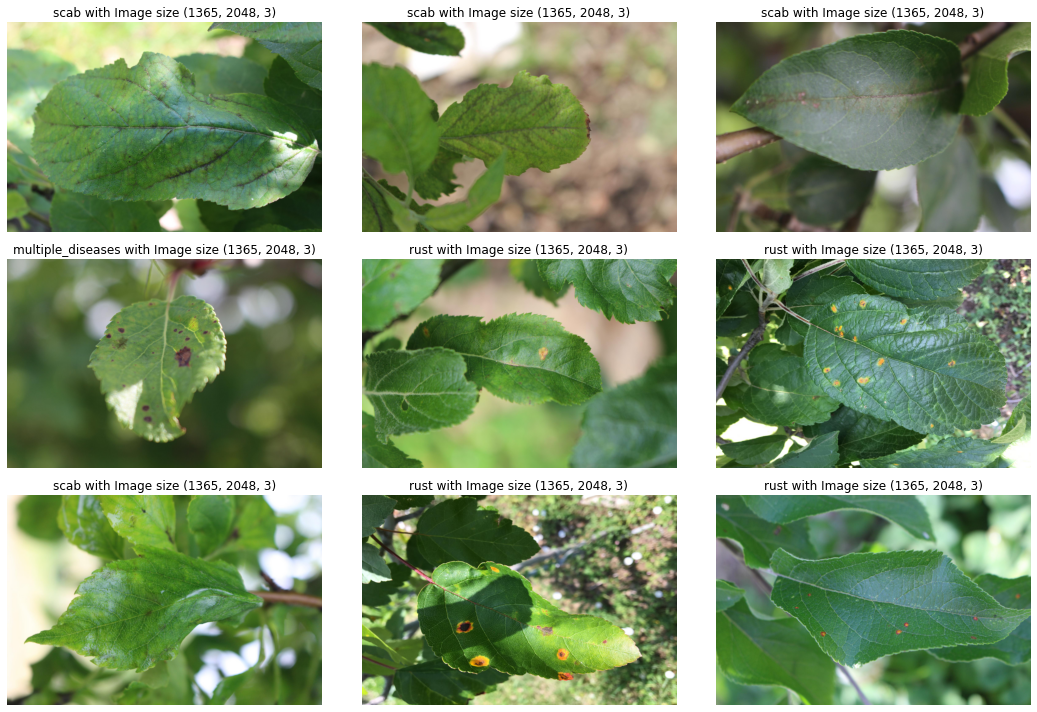

In [ ]:
plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    read_plot_random_image()
    plt.axis(False)
plt.tight_layout()
plt.show()

In [ ]:
#if above block of code ran multiple times you will observe shape of all the images are same.
#From here we decide the preprocessing function. We will need only to rescale image and can use a common size for all images

<AxesSubplot:>

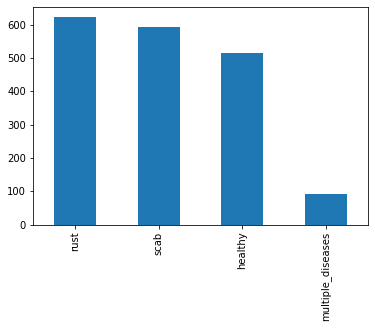

In [ ]:
df_train['label'].value_counts().plot(kind='bar')

In [ ]:
#observation
#Plants having multiple disease are much less in number

Task 2:

a. When the data is scarse we can use image augmentation techniques to make the model. These techniques involves image rotation, crop , adding noise etc

b. Some basic augmentation that can be folllowed here:
 1. Crop : It will randomly crop the images
 2. Flip : It will provide random flips
 3. LinearContrast : Strengthen or weaken the contrast in each image
 4. AdditiveGaussianNoise : Add gaussian noise
 
c. Instead ImageDatGenerator 'imgaug' will be used for doing image augmentation

In [ ]:
# !pip install imgaug

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa

In [ ]:
#making a augmentation object which will augment image
augmentation = iaa.Sequential([
    # 1. Flip
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    # 2. Affine
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
               rotate=(-30, 30),
               scale=(0.5, 1.5)),
    # 3. Multiply
    iaa.Multiply((0.8, 1.2)),
    # 4. Linearcontrast
    iaa.LinearContrast((0.6, 1.4)),
    # Perform methods below only sometimes
    iaa.Sometimes(0.5,
        # 5. GaussianBlur
        iaa.GaussianBlur((0.0, 3.0))
        )
])

In [ ]:
#we will select a random image and will call augmentation object for each image

In [ ]:
#choosing a random image
path='/content/images/'
rand_img = np.random.choice(path + df_train['image'])
rand_img = plt.imread(rand_img)

In [ ]:
#making 'N' copies of each image so that we can how how augmented image looks like
N=32

images_N = np.array(
    [rand_img for _ in range(N)],
    dtype=np.uint8
)

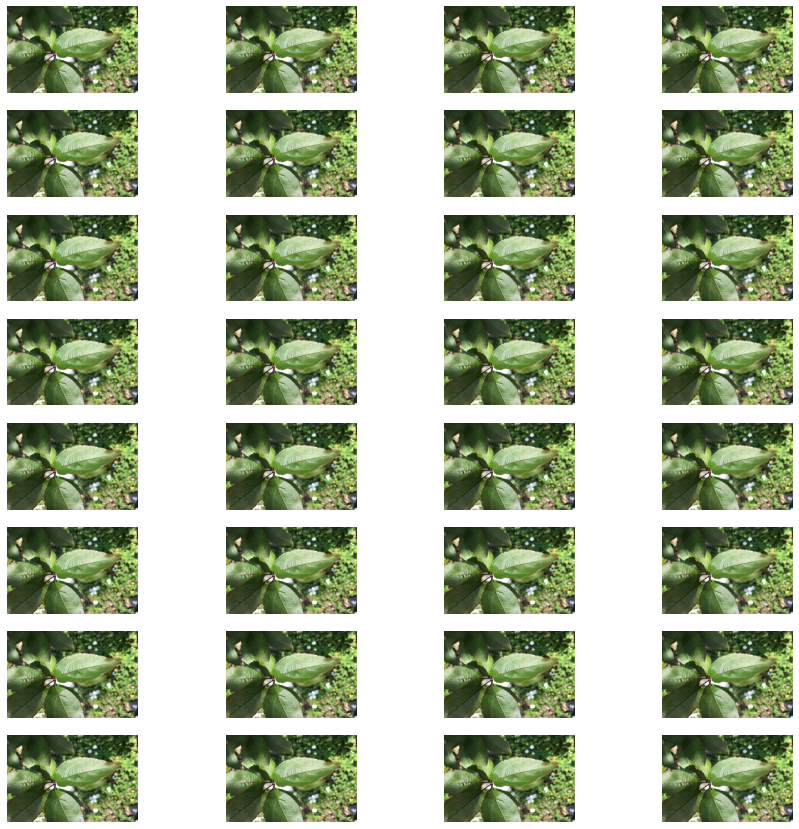

In [ ]:
#viewing original image
plt.figure(figsize=(15,15))
for i in range(32):
  plt.subplot(8,4,i+1)
  plt.imshow(images_N[i])
  plt.axis(False)

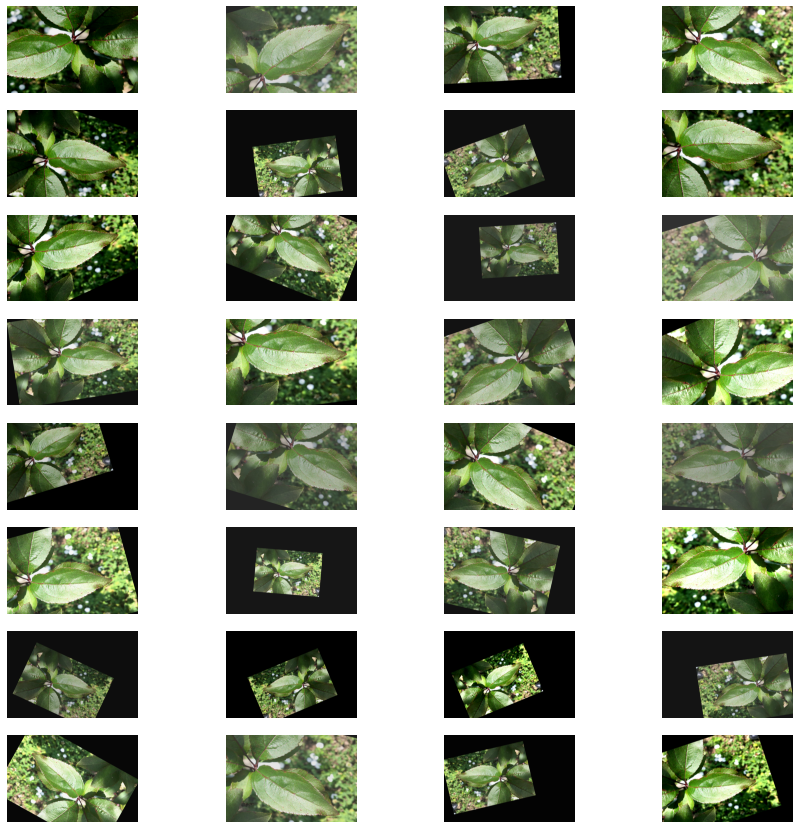

In [ ]:
#viewing augmented images
images_aug = augmentation(images=images_N)

plt.figure(figsize=(15,15))
for i in range(32):
    plt.subplot(8,4,i+1)
    plt.imshow(X=images_aug[i])
    plt.axis(False)
    
plt.show()

Task 3

In [ ]:
df_train

,image_id,healthy,multiple_diseases,rust,scab,classes,label,label_index,image
0,Train_0,0,0,0,1,"[0, 0, 0, 1]",scab,3,Train_0.jpg
1,Train_1,0,1,0,0,"[0, 1, 0, 0]",multiple_diseases,1,Train_1.jpg
2,Train_2,1,0,0,0,"[1, 0, 0, 0]",healthy,0,Train_2.jpg
3,Train_3,0,0,1,0,"[0, 0, 1, 0]",rust,2,Train_3.jpg
4,Train_4,1,0,0,0,"[1, 0, 0, 0]",healthy,0,Train_4.jpg
...,...,...,...,...,...,...,...,...,...
1816,Train_1816,0,0,0,1,"[0, 0, 0, 1]",scab,3,Train_1816.jpg
1817,Train_1817,1,0,0,0,"[1, 0, 0, 0]",healthy,0,Train_1817.jpg
1818,Train_1818,1,0,0,0,"[1, 0, 0, 0]",healthy,0,Train_1818.jpg
1819,Train_1819,0,0,1,0,"[0, 0, 1, 0]",rust,2,Train_1819.jpg


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True,
                                             validation_split=.2) # flip the image on the horizontal axis


train_data = train_datagen_augmented.flow_from_dataframe(df_train, 
                                    x_col="image", y_col="label",
                                    directory='/content/images/', 
                                    target_size=(224, 224),batch_size=32, 
                                    subset="training",
                                    shuffle=True)

val_data = train_datagen_augmented.flow_from_dataframe(df_train, 
                                    x_col="image", y_col="label", 
                                    directory='/content/images/', 
                                    target_size=(224, 224),batch_size=32, 
                                    subset="validation",
                                    shuffle=True)

Found 1457 validated image filenames belonging to 4 classes.
Found 364 validated image filenames belonging to 4 classes.


In [ ]:
# model_1
model_1 = tf.keras.models.Sequential()
model_1.add(tf.keras.layers.Input((224, 224, 3)))
model_1.add(tf.keras.layers.Flatten())
model_1.add(tf.keras.layers.Dense(120, activation = tf.keras.activations.relu))
model_1.add(tf.keras.layers.Dense(4, activation = tf.keras.activations.softmax))

#compliing the model_1
model_1.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = tf.keras.losses.categorical_crossentropy, 
              metrics = ["acc"])
			  

#fitting the model_1
history_1=model_1.fit(train_data, batch_size=32, epochs=10,validation_data=val_data)


KeyboardInterrupt: ignored

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['acc']
  val_accuracy = history.history['val_acc']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

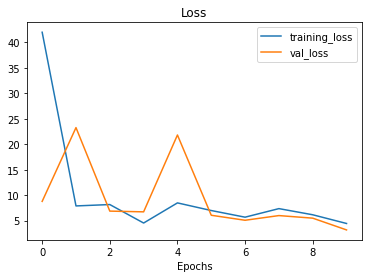

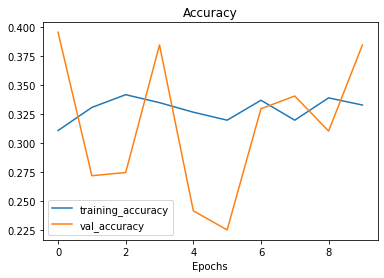

In [ ]:
plot_loss_curves(history_1)

In [ ]:
#model_2
model_2 = tf.keras.models.Sequential()
model_2.add(tf.keras.layers.Input((224, 224, 3)))
model_2.add(tf.keras.layers.Flatten())
model_2.add(tf.keras.layers.Dense(1000, activation = tf.keras.activations.relu))
model_2.add(tf.keras.layers.Dense(400, activation = tf.keras.activations.relu))
model_2.add(tf.keras.layers.Dense(4, activation = tf.keras.activations.softmax))

model_2.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = tf.keras.losses.categorical_crossentropy, 
              metrics = ["acc"])

history_2=model_2.fit(train_data, batch_size=32, epochs=10,validation_data=val_data)

Epoch 1/10
46/46 [==============================] - 73s 2s/step - loss: 64.8027 - acc: 0.3068 - val_loss: 7.5914 - val_acc: 0.2637
Epoch 2/10
46/46 [==============================] - 71s 2s/step - loss: 9.0124 - acc: 0.3198 - val_loss: 4.7458 - val_acc: 0.2527
Epoch 3/10
46/46 [==============================] - 71s 2s/step - loss: 2.9198 - acc: 0.3500 - val_loss: 3.2662 - val_acc: 0.2390
Epoch 4/10
46/46 [==============================] - 70s 2s/step - loss: 1.8876 - acc: 0.3439 - val_loss: 1.5652 - val_acc: 0.3297
Epoch 5/10
46/46 [==============================] - 71s 2s/step - loss: 1.6818 - acc: 0.3102 - val_loss: 2.0934 - val_acc: 0.3846
Epoch 6/10
46/46 [==============================] - 71s 2s/step - loss: 1.6327 - acc: 0.3288 - val_loss: 1.4264 - val_acc: 0.2418
Epoch 7/10
46/46 [==============================] - 72s 2s/step - loss: 1.3197 - acc: 0.3425 - val_loss: 1.2344 - val_acc: 0.3736
Epoch 8/10
46/46 [==============================] - 71s 2s/step - loss: 1.2968 - acc: 0.3

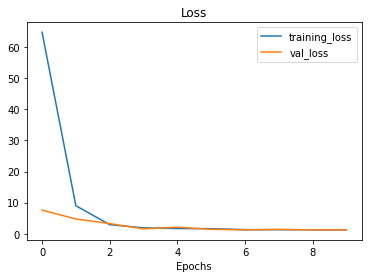

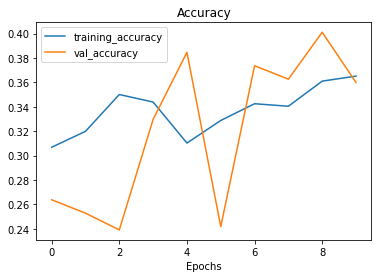

In [ ]:
plot_loss_curves(history_2)

In [ ]:
#callback to stop model from training
early_stopping =tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=4)

In [ ]:
vgg_conv_model = tf.keras.applications.VGG16(include_top=False, input_shape=(224, 224, 3))

for layer in vgg_conv_model.layers:
  layer.trainable = False

flatten = tf.keras.layers.Flatten() (vgg_conv_model.output)
dense1 = tf.keras.layers.Dense(64, activation='relu') (flatten)
dense2 = tf.keras.layers.Dense(64, activation='relu') (dense1)
pred = tf.keras.layers.Dense(4, activation='softmax') (dense2)

full_model = tf.keras.models.Model(inputs=[vgg_conv_model.input], outputs=[pred])

full_model.compile(tf.keras.optimizers.Adam(), loss=tf.keras.losses.categorical_crossentropy, 
                   metrics = ["acc"])

history_3=full_model.fit(train_data, batch_size=32, epochs=10,validation_data=val_data,callbacks=early_stopping)


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
46/46 [==============================] - 99s 2s/step - loss: 1.2910 - acc: 0.4413 - val_loss: 1.1194 - val_acc: 0.5632
Epoch 2/10
46/46 [==============================] - 88s 2s/step - loss: 1.0243 - acc: 0.5800 - val_loss: 1.0335 - val_acc: 0.6071
Epoch 3/10
46/46 [==============================] - 86s 2s/step - loss: 0.9470 - acc: 0.6218 - val_loss: 1.0271 - val_acc: 0.5742
Epoch 4/10
46/46 [==============================] - 84s 2s/step - loss: 0.9110 - acc: 0.6342 - val_loss: 0.9455 - val_acc: 0.6374
Epoch 5/10
46/46 [==============================] - 83s 2s/step - loss: 0.8673 - acc: 0.6664 - val_loss: 0.9718 - val_acc: 0.6566
Epoch 6/10
46/46 [==============================] - 85s 2s/step - loss: 0.8789 - acc: 0.6472 - val_loss: 0.8954 - val_acc: 0.6511
Epoch 7/10
46/46 [==============================] - 82s 2s/step - loss: 0.8778 - acc: 0.6452 - val_loss: 1.0633 - val_acc: 0.5879
Epoch 8/10
46/46 [=======

In [ ]:
plot_loss_curves(history_3)

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import layers

model_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
IMAGE_SHAPE =(224,224)

import tensorflow_hub as hub
def create_model(model_url, num_classes,IMAGE_SHAPE=(224,224)):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model  

In [ ]:
# Create model
efficientnet_model = create_model(model_url=model_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=4)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=40, 
                                              steps_per_epoch=len(train_data),
                                              validation_data=val_data,
                                              validation_steps=len(val_data),
                                              callbacks=early_stopping
                                              )

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/40
46/46 [==============================] - 107s 2s/step - loss: 1.0689 - accuracy: 0.5649 - val_loss: 0.8749 - val_accuracy: 0.6786
Epoch 2/40
46/46 [==============================] - 86s 2s/step - loss: 0.7783 - accuracy: 0.7481 - val_loss: 0.7154 - val_accuracy: 0.7637
Epoch 3/40
46/46 [==============================] - 85s 2s/step - loss: 0.6827 - accuracy: 0.7749 - val_loss: 0.6520 - val_accuracy: 0.7912
Epoch 4/40
46/46 [==============================] - 83s 2s/step - loss: 0.6199 - accuracy: 0.7962 - val_loss: 0.6343 - val_accuracy: 0.7802
Epoch 5/40
46/46 [==============================] - 80s 2s/step - loss: 0.5903 - accuracy: 0.7907 - val_loss: 0.5873 - val_accuracy: 0.7802
Epoch 6/40
46/46 [==============================] - 83s 2s/step - loss: 0.5455 - accuracy: 0.8195 - val_loss: 0.5906 - val_accuracy: 0.8132
Epoch 7/40
46/46 [==============================] - 80s 2s/step - loss: 0.5213 - accuracy: 0.8373 - val_loss: 0.5841 - val_accuracy: 0.7995
Epoch 8/40
46/46 [=

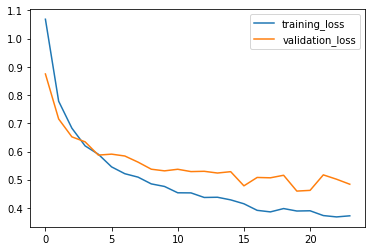

In [ ]:
plt.plot(range(len(efficientnet_history.history['loss'])), efficientnet_history.history['loss'], label='training_loss')
plt.plot(range(len(efficientnet_history.history['val_loss'])), efficientnet_history.history['val_loss'], label='validation_loss')
plt.legend()

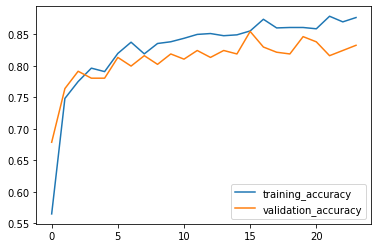

In [ ]:
plt.plot(range(len(efficientnet_history.history['accuracy'])), efficientnet_history.history['accuracy'], label='training_accuracy')
plt.plot(range(len(efficientnet_history.history['val_accuracy'])), efficientnet_history.history['val_accuracy'], label='validation_accuracy')
plt.legend()

Task 4

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
val_filenames=val_data.filenames

In [ ]:
val_labels=[]

for i in range(len(val_filenames)):
  a=df_train['label_index'][df_train['image']==val_filenames[i]]
  val_labels.append(a)

val_labels=np.array(val_labels)

In [ ]:
y_preds = efficientnet_model.predict(val_data)

12/12 [==============================] - 17s 1s/step


In [ ]:
y_preds = np.argmax(y_preds,axis=1)
y_preds

array([2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 0, 3, 3, 0, 0, 3, 0, 2, 2, 2, 0, 0,
       0, 0, 3, 0, 0, 3, 3, 3, 0, 3, 0, 3, 0, 2, 3, 0, 2, 2, 3, 2, 3, 2,
       2, 2, 2, 0, 3, 2, 2, 3, 2, 0, 2, 3, 2, 2, 0, 0, 3, 3, 0, 3, 3, 0,
       2, 0, 0, 3, 3, 0, 3, 2, 3, 2, 2, 0, 2, 3, 3, 2, 3, 3, 2, 2, 3, 0,
       2, 0, 0, 0, 2, 2, 3, 3, 3, 2, 3, 2, 2, 3, 2, 0, 2, 0, 3, 3, 2, 0,
       2, 3, 2, 2, 3, 2, 0, 2, 0, 2, 0, 2, 3, 0, 2, 2, 0, 0, 2, 2, 0, 3,
       0, 3, 3, 3, 0, 2, 3, 3, 3, 3, 0, 0, 2, 3, 2, 2, 3, 3, 3, 0, 2, 2,
       0, 3, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 3, 3, 0, 0, 3, 0, 3, 3, 0,
       3, 2, 0, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 0, 2, 0, 2, 3, 0, 2, 3, 3,
       0, 0, 3, 3, 3, 0, 3, 2, 2, 3, 0, 2, 2, 0, 2, 0, 2, 3, 3, 3, 2, 2,
       0, 2, 3, 2, 0, 3, 0, 3, 0, 0, 3, 0, 2, 3, 1, 0, 0, 0, 2, 2, 0, 0,
       2, 3, 0, 0, 3, 3, 3, 1, 0, 0, 0, 3, 3, 3, 2, 0, 0, 0, 3, 0, 3, 3,
       2, 3, 0, 2, 0, 0, 2, 0, 3, 0, 0, 3, 0, 2, 3, 3, 0, 3, 3, 3, 3, 0,
       3, 0, 3, 3, 3, 2, 0, 0, 2, 0, 2, 1, 2, 0, 3,

In [ ]:
confusion_matrix(val_labels,y_preds)

array([[29,  1, 28, 30],
       [ 6,  0,  8,  6],
       [41,  1, 34, 40],
       [42,  3, 44, 51]])

Task 5

In [ ]:
efficientnet_model.save('Plant pathology DL model')

In [ ]:
#loading a saved model
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/Plant pathology DL model')

In [ ]:
y_preds_loaded=loaded_model.predict(val_data)
y_preds_loaded = np.argmax(y_preds_loaded,axis=1)

12/12 [==============================] - 15s 1s/step


In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
efficientnet_model.save('/content/gdrive/MyDrive/models/PP/efficientnet_model')

In [ ]:
loaded_efficientnet_model = tf.keras.models.load_model('/content/gdrive/MyDrive/models/PP/efficientnet_model') 

In [ ]:
df_test['image_path']= '/content/images/' + df_test['image_id'] + '.jpg'

In [ ]:
df_test

,image_id,image_path
0,Test_0,/content/images/Test_0.jpg
1,Test_1,/content/images/Test_1.jpg
2,Test_2,/content/images/Test_2.jpg
3,Test_3,/content/images/Test_3.jpg
4,Test_4,/content/images/Test_4.jpg
...,...,...
1816,Test_1816,/content/images/Test_1816.jpg
1817,Test_1817,/content/images/Test_1817.jpg
1818,Test_1818,/content/images/Test_1818.jpg
1819,Test_1819,/content/images/Test_1819.jpg


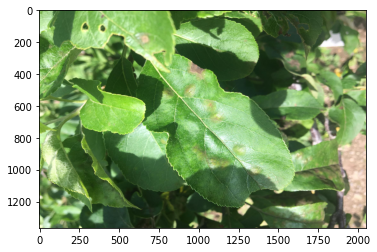

In [ ]:
import cv2

image_1 = cv2.imread('/content/images/Test_1820.jpg')
image_1 = cv2.cvtColor(image_1,cv2.COLOR_BGR2RGB)
plt.imshow(image_1)

Text(0.5, 1.0, 'scab')

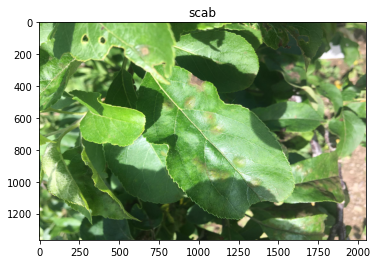

In [ ]:
image = cv2.resize(image_1, (224,224))

image = image/255.0

image = np.expand_dims(image,axis=0)
pred = efficientnet_model.predict(image,verbose=0)
predicted_class = unique_class[np.argmax(pred)]
plt.imshow(image_1)
plt.title(predicted_class)